# Packages

In [1]:
import datetime
import math
import statistics
from collections import defaultdict
from itertools import chain
from random import random, seed
from statistics import mean, pstdev

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F  # All functions that don't have any parameters
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from ChannelAttribution import *
from IPython.display import clear_output
from sklearn import metrics, preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from Transition_Prob_Functions import *

Looking for attribution at path level? Try markov_model_local_api() or ask for ChannelAttributionPro at info@channelattribution.io! Visit https://channelattribution.io for more information.
Version: 2.1.3


# Data


In [2]:
df = pd.read_csv("attribution data.csv")
df["time"] = df["time"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")
)
channels = df["channel"].unique()

In [3]:
# Creating customer journies from raw data
Data = (
    df.groupby("cookie")
    .agg(
        {
            "time": lambda x: list(x),
            "channel": lambda x: list(x),
            "conversion": lambda x: list(x),
        }
    )
    .reset_index()
)

# Conversion dummy
Data["conversion"] = Data["conversion"].apply(lambda x: sum(x))
Data["null"] = Data["conversion"].apply(lambda x: 1 if x == 0 else 0)
Data["Markov_Path"] = Data["channel"].apply(lambda x: ">".join(x))
Data["path"] = Data.apply(
    lambda x: ["Start"] + x["channel"] + ["Null"]
    if x["conversion"] == 0
    else ["Start"] + x["channel"] + ["Conversion"],
    axis=1,
)

# Adding Null and Conversion to path
Data["path_use"] = Data.apply(
    lambda x: x["channel"][:-1] + ["Null"]
    if x["conversion"] == 0
    else x["channel"][:-1] + ["Conversion"],
    axis=1,
)

# Creating tuples as arcs and higher order chains
Data["Arc"] = Data["path_use"].apply(lambda x: [(i, j) for i, j in zip(x, x[1:])])
Data["Arc_3"] = Data["path_use"].apply(
    lambda x: [(i, j, k) for i, j, k in zip(x, x[1:], x[2:])]
)
Data["Arc_4"] = Data["path_use"].apply(
    lambda x: [(i, j, k, l) for i, j, k, l in zip(x, x[1:], x[2:], x[3:])]
)

# Time difference variable
Data["time_diff"] = Data["time"].apply(
    lambda x: [
        int(j.strftime("%s")) - int(i.strftime("%s")) for i, j in zip(x[:-1], x[1:])
    ]
)
Data["time_diff_2"] = Data["time"].apply(
    lambda x: [
        int(j.strftime("%s")) - int(i.strftime("%s")) for i, j in zip(x[1:-1], x[2:])
    ]
)

# First and Last touch of model
Data["first_touch"] = Data["channel"].apply(lambda x: x[0])
Data["last_touch"] = Data["channel"].apply(lambda x: x[-1])
Data["Arc_str"] = Data["channel"].apply(
    lambda x: [i + " , " + j for i, j in zip(x, x[1:])]
)
Data["Arc_2nd_order_use"] = Data.apply(
    lambda x: x["Arc_str"] + ["Conversion"]
    if x["conversion"] == 1
    else x["Arc_str"] + ["Null"],
    axis=1,
)

# Arcs and tuples as strings for model
Data["Arc_str"] = Data.apply(
    lambda x: ["Start"] + x["Arc_str"] + ["Conversion"]
    if x["conversion"] == 1
    else ["Start"] + x["Arc_str"] + ["Null"],
    axis=1,
)

Data["Arc_2nd_order"] = Data["Arc_2nd_order_use"].apply(
    lambda x: [(i, j) for i, j in zip(x, x[1:])]
)

Data["Arc_3_str"] = Data["channel"].apply(
    lambda x: [i + " , " + j + " , " + k for i, j, k in zip(x, x[1:], x[2:])]
)
Data["Arc_3_str"] = Data.apply(
    lambda x: ["Start"] + x["Arc_3_str"] + ["Conversion"]
    if x["conversion"] == 1
    else ["Start"] + x["Arc_3_str"] + ["Null"],
    axis=1,
)

Data["Arc_4_str"] = Data["channel"].apply(
    lambda x: [
        i + " , " + j + " , " + k + " , " + l
        for i, j, k, l in zip(x, x[1:], x[2:], x[3:])
    ]
)
Data["Arc_4_str"] = Data.apply(
    lambda x: ["Start"] + x["Arc_4_str"] + ["Conversion"]
    if x["conversion"] == 1
    else ["Start"] + x["Arc_4_str"] + ["Null"],
    axis=1,
)

# Last k touches for the Neural Network model

Data["last_2_touch"] = Data["Arc"].apply(lambda x: x[-2] if len(x) > 1 else 0)
Data["last_2_touch"] = Data["last_2_touch"].apply(
    lambda x: " , ".join(x) if x != 0 else 0
)
Data["last_3_touch"] = Data["Arc_3"].apply(lambda x: x[-2] if len(x) > 1 else 0)
Data["last_3_touch"] = Data["last_3_touch"].apply(
    lambda x: " , ".join(x) if x != 0 else 0
)
Data["last_4_touch"] = Data["Arc_4"].apply(lambda x: x[-2] if len(x) > 1 else 0)
Data["last_4_touch"] = Data["last_4_touch"].apply(
    lambda x: " , ".join(x) if x != 0 else 0
)
channels_2_order = set(x for element in Data["Arc_str"] for x in element)
channels_2_order.remove("Start")
channels_2_order.remove("Null")
channels_2_order.remove("Conversion")

In [4]:
Data.head()

,cookie,time,channel,conversion,null,Markov_Path,path,path_use,Arc,Arc_3,...,first_touch,last_touch,Arc_str,Arc_2nd_order_use,Arc_2nd_order,Arc_3_str,Arc_4_str,last_2_touch,last_3_touch,last_4_touch
0,00000FkCnDfDDf0iC97iC703B,"[2018-07-03 13:02:11, 2018-07-17 19:15:07, 201...","[Instagram, Online Display, Online Display, On...",0,1,Instagram>Online Display>Online Display>Online...,"[Start, Instagram, Online Display, Online Disp...","[Instagram, Online Display, Online Display, Null]","[(Instagram, Online Display), (Online Display,...","[(Instagram, Online Display, Online Display), ...",...,Instagram,Online Display,"[Start, Instagram , Online Display, Online Dis...","[Instagram , Online Display, Online Display , ...","[(Instagram , Online Display, Online Display ,...","[Start, Instagram , Online Display , Online Di...","[Start, Instagram , Online Display , Online Di...","Online Display , Online Display","Instagram , Online Display , Online Display",0
1,0000nACkD9nFkBBDECD3ki00E,"[2018-07-03 09:44:57, 2018-07-03 23:36:49, 201...","[Paid Search, Paid Search, Paid Search, Paid S...",0,1,Paid Search>Paid Search>Paid Search>Paid Searc...,"[Start, Paid Search, Paid Search, Paid Search,...","[Paid Search, Paid Search, Paid Search, Paid S...","[(Paid Search, Paid Search), (Paid Search, Pai...","[(Paid Search, Paid Search, Paid Search), (Pai...",...,Paid Search,Paid Search,"[Start, Paid Search , Paid Search, Paid Search...","[Paid Search , Paid Search, Paid Search , Paid...","[(Paid Search , Paid Search, Paid Search , Pai...","[Start, Paid Search , Paid Search , Paid Searc...","[Start, Paid Search , Paid Search , Paid Searc...","Paid Search , Paid Search","Paid Search , Paid Search , Paid Search","Paid Search , Paid Search , Paid Search , Paid..."
2,0003EfE37E93D0BC03iBhBBhF,"[2018-07-08 10:48:21, 2018-07-09 13:06:42, 201...","[Paid Search, Paid Search, Paid Search, Paid S...",0,1,Paid Search>Paid Search>Paid Search>Paid Searc...,"[Start, Paid Search, Paid Search, Paid Search,...","[Paid Search, Paid Search, Paid Search, Paid S...","[(Paid Search, Paid Search), (Paid Search, Pai...","[(Paid Search, Paid Search, Paid Search), (Pai...",...,Paid Search,Paid Search,"[Start, Paid Search , Paid Search, Paid Search...","[Paid Search , Paid Search, Paid Search , Paid...","[(Paid Search , Paid Search, Paid Search , Pai...","[Start, Paid Search , Paid Search , Paid Searc...","[Start, Paid Search , Paid Search , Paid Searc...","Paid Search , Paid Search","Paid Search , Paid Search , Paid Search","Paid Search , Paid Search , Paid Search , Paid..."
3,00073CFE3FoFCn70fBhB3kfon,[2018-07-21 10:52:04],[Instagram],0,1,Instagram,"[Start, Instagram, Null]",[Null],[],[],...,Instagram,Instagram,"[Start, Null]",[Null],[],"[Start, Null]","[Start, Null]",0,0,0
4,00079hhBkDF3k3kDkiFi9EFAD,[2018-07-10 11:11:24],[Paid Search],0,1,Paid Search,"[Start, Paid Search, Null]",[Null],[],[],...,Paid Search,Paid Search,"[Start, Null]",[Null],[],"[Start, Null]","[Start, Null]",0,0,0


# Data Analysis

In [5]:
Data["path_length"] = Data["channel"].apply(lambda x: len(x))

In [6]:
Stats = [
    "Number of Different Channels",
    "Number of Clicks",
    "Number of Journeys",
    "Length >= 2",
    "Length >= 5",
    "Journey Length",
    "Journey Length Std dev",
    "Number of Conversions",
    "Conversion Rate",
]
dataset1_stats = [
    5,
    Data["path_length"].sum(),
    len(Data["path_length"]),
    len(Data[Data["path_length"] >= 2]),
    len(Data[Data["path_length"] >= 5]),
    Data["path_length"].mean(),
    Data["path_length"].std(),
    Data["conversion"].sum(),
    Data["conversion"].sum() / len(Data["path_length"]),
]

Statistics = pd.DataFrame({"Description": Stats, "Stats": dataset1_stats})

In [7]:
Statistics

,Description,Stats
0,Number of Different Channels,5.000000
1,Number of Clicks,586737.000000
2,Number of Journeys,240108.000000
3,Length >= 2,116644.000000
4,Length >= 5,26805.000000
5,Journey Length,2.443638
6,Journey Length Std dev,3.104849
7,Number of Conversions,17639.000000
8,Conversion Rate,0.073463


In [8]:
conversion_time = []
null_time = []
total_time = []

# Time difference of conversion and non-conversion

Data[Data["conversion"] == 1]["time_diff"].apply(
    lambda x: conversion_time.append(x[-1]) if len(x) > 0 else 0
)
Data[Data["conversion"] == 0]["time_diff"].apply(
    lambda x: null_time.append(x[-1]) if len(x) > 0 else 0
)
Data["time_diff"].apply(lambda x: total_time.append(x[:-1]) if len(x) > 1 else 0)
flatten_list = list(chain.from_iterable(total_time))

# Mean time differences between being in conversion, non-conversion and inter-channel
statistics.mean(conversion_time), statistics.mean(null_time), statistics.mean(
    flatten_list
)

(246321.01878301703, 344991.386564808, 209687.2416461943)

[Text(0.5, 0, '')]

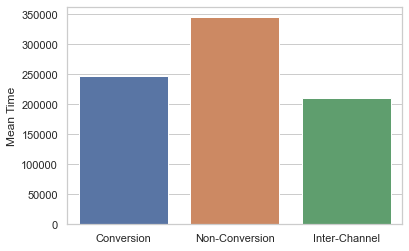

In [9]:
time_df = pd.DataFrame(
    {
        "Next Click": ["Conversion", "Non-Conversion", "Inter-Channel"],
        "Mean Time": [
            statistics.mean(conversion_time),
            statistics.mean(null_time),
            statistics.mean(flatten_list),
        ],
        "Actual": [conversion_time, null_time, flatten_list],
    }
)
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="Next Click", y="Mean Time", data=time_df)
ax.set(xlabel=None)

In [10]:
max(conversion_time)

2520087

[Text(1, 0, 'Conversion Time'),
 Text(2, 0, 'Null Time'),
 Text(3, 0, 'Inter-Channel Time')]

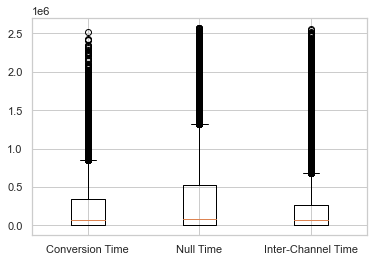

In [11]:
figure_dict = {
    "Conversion Time": conversion_time,
    "Null Time": null_time,
    "Inter-Channel Time": flatten_list,
}
fig, ax = plt.subplots()
ax.boxplot(figure_dict.values())
ax.set_xticklabels(figure_dict.keys())

# Models

## Click Heuristic Model

In [12]:
class Heuristic:
    def __init__(self, first_element, conversion):
        self.first_element = first_element
        self.conversion = conversion
        self.prob_first = {}
        self.all_channels = {}
        self.converted_channels = {}

    def fit_touch(self):
        # Find unique channels and number of times it was a click in position
        unique_all, counts_all = np.unique(self.first_element, return_counts=True)
        # Find unique channels and number of times it was a click in position given conversion
        unique, counts = np.unique(
            self.first_element[np.where(self.conversion == 1)], return_counts=True
        )
        counter1 = 0
        counter2 = 0
        for i in unique_all:
            self.all_channels[i] = counts_all[counter1]
            counter1 += 1

        for i in unique:
            self.converted_channels[i] = counts[counter2]
            counter2 += 1

        # Create probabilities of every channel
        for i in unique_all:
            if i in self.converted_channels:
                self.prob_first[i] = float(
                    self.converted_channels[i] / self.all_channels[i]
                )
            else:
                self.prob_first[i] = 0

    def predict_touch(self, x):
        first_pred = []
        # Find element in probability dictionary
        for i in x:
            if i in self.prob_first:
                first_pred.append(self.prob_first[i])
            else:
                first_pred.append(0)
        return np.asarray(first_pred)

## Logit Model 1 (Simple)

In [13]:
def path_to_list_converter(x, output_size=5):
    # Convert clicks into number of time channel appeared in journey
    index_dict = {
        "Instagram": 0,
        "Online Display": 1,
        "Paid Search": 2,
        "Facebook": 3,
        "Online Video": 4,
    }
    output = [0] * output_size

    for i in x:
        output[index_dict[i]] += 1

    return output


logit_data = Data[["conversion", "path"]]
logit_data = logit_data.sample(frac=1).reset_index(drop=True)
logit_data["path"] = logit_data["path"].apply(lambda x: x[1:-1])
logit_data["X1"] = logit_data["path"].apply(path_to_list_converter)

In [14]:
y1 = logit_data["conversion"].to_numpy()
X1 = np.array(logit_data["X1"].to_list())
X1 = sm.add_constant(X1)
Logit1 = sm.Logit(y1, X1).fit()
print(Logit1.summary())

Optimization terminated successfully.
         Current function value: 0.258334
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               240108
Model:                          Logit   Df Residuals:                   240102
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                 0.01589
Time:                        10:37:57   Log-Likelihood:                -62028.
converged:                       True   LL-Null:                       -63030.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7256      0.010   -268.519      0.000      -2.746      -2.706
x1             0.0790      0.

## Logit Model 2 (Dynamic)

In [15]:
def path_to_dummy_converter(x, output_size=5):
    # Convert sequence of clicks into dummies where output size is the number of channels
    input1 = x[-4:]
    index_dict = {
        "Instagram": 0,
        "Online Display": 1,
        "Paid Search": 2,
        "Facebook": 3,
        "Online Video": 4,
    }
    output = [0] * output_size * 4
    counter = 0
    for i in input1:
        index = 4 * index_dict[i] + counter
        output[index] = 1
        counter += 1

    return output


logit_data["X2"] = logit_data["path"].apply(path_to_dummy_converter)

In [16]:
y2 = logit_data["conversion"].to_numpy()
X2 = np.array(logit_data["X2"].to_list())
X2 = sm.add_constant(X2)
Logit2 = sm.Logit(y2, X2).fit(maxiter=1000)
print(Logit2.summary())

Optimization terminated successfully.
         Current function value: 0.258007
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               240108
Model:                          Logit   Df Residuals:                   240087
Method:                           MLE   Df Model:                           20
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                 0.01714
Time:                        10:38:00   Log-Likelihood:                -61949.
converged:                       True   LL-Null:                       -63030.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2811        nan        nan        nan         nan         nan
x1            -0.4114       

## Markov Model

## Removal Effects and Stochastic Simulation

In [17]:
### Simulates a multinomial values over the probabilites given
def simulate_multinomial(vmultinomial):
    r = np.random.uniform(0.0, 1.0)
    CS = np.cumsum(vmultinomial)
    CS = np.insert(CS, 0, 0)
    m = (np.where(CS < r))[0]
    nextState = m[len(m) - 1]

    return nextState


### Runs a simulation on the transition matrix
def run_simulation(trans_matrix_df, sim_size=10000, path_max=15):
    # Sorting index to ensure simulation runs without issue
    new_trans_matrix_df = trans_matrix_df.sort_index(ascending=True)
    new_trans_matrix_df = new_trans_matrix_df.reindex(
        sorted(new_trans_matrix_df.columns), axis=1
    )
    index = np.array(new_trans_matrix_df.index)
    columns = np.array(new_trans_matrix_df.columns)
    # Store when sim entered conversion
    ind_conversion = np.where(columns == "Conversion")
    P = new_trans_matrix_df.to_numpy()
    conversion_counter = np.zeros(P.shape[1])
    state_counter = np.zeros(P.shape[1])
    total_counter = np.zeros(P.shape[1])

    for x in tqdm(range(sim_size)):
        next_state = np.where(index == "Start")
        state_visit = np.full(P.shape[1], False)
        path_length = np.random.randint(0, path_max)
        for y in range(path_length):
            # Only count starting channel after start
            if y == 1:
                initial_state = next_state
                total_counter[initial_state] += 1

            # Find next channel
            next_state = simulate_multinomial(P[next_state])
            # Check for conversion
            if next_state == ind_conversion:
                conversion_counter[initial_state] += 1
            # Count number of times state entered before conversion
            if state_visit[next_state] == False:
                state_counter[next_state] += 1
                state_visit[next_state] = True

    ## Results
    Sim_Results = pd.DataFrame(
        {
            "State": new_trans_matrix_df.index,
            "Conversion": conversion_counter,
            "Visits": state_counter,
            "Total_Ends": total_counter,
            "Eventual_Conversion": conversion_counter / total_counter,
            "Visit_Probability": state_counter / sim_size,
        }
    )
    Sim_Results = Sim_Results.fillna(0)
    Sim_Results["Removal_Effect"] = (
        Sim_Results["Eventual_Conversion"] * Sim_Results["Visit_Probability"]
    )
    Sim_Results["Removal_Effect_%"] = (
        Sim_Results["Removal_Effect"] / Sim_Results["Removal_Effect"].sum()
    ) * 100

    return Sim_Results


# s = run_simulation(New_Transition_Matrix)

## General Markov Order 1

In [18]:
# Find list of paths
list_of_paths = Data["path"]
trans_states = transition_states(list_of_paths)
# Find transition probabilites of paths
trans_prob = transition_prob(trans_states, list_of_paths)
# Construct transition matrix
trans_matrix_order1 = transition_matrix(list_of_paths, trans_prob)
simulation_conversions = run_simulation(trans_matrix_order1)

trans_matrix_order1

100%|██████████| 10000/10000 [00:01<00:00, 5805.32it/s]
/Users/george/Documents/Python_Stuff/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


,Null,Conversion,Instagram,Online Display,Paid Search,Facebook,Online Video,Start
Null,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Conversion,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Instagram,0.363772,0.029840,0.159586,0.018683,0.033351,0.372522,0.022247,0.0
Online Display,0.457025,0.030104,0.021069,0.349007,0.077351,0.048992,0.016453,0.0
Paid Search,0.443073,0.030025,0.022656,0.041475,0.385981,0.052054,0.024736,0.0
Facebook,0.363108,0.030164,0.159394,0.018197,0.034010,0.373140,0.021987,0.0
Online Video,0.280030,0.030079,0.014492,0.009894,0.024677,0.034765,0.606062,0.0
Start,0.000000,0.000000,0.119188,0.142644,0.317399,0.278408,0.142361,0.0


## General Markov Order 2

In [21]:
# Find list of paths
list_of_paths = Data["Arc_str"]
trans_states = transition_states(list_of_paths)
# Find transition probabilites of paths
trans_prob = transition_prob(trans_states, list_of_paths)
# Construct transition matrix
trans_matrix_order2 = transition_matrix(list_of_paths, trans_prob)
simulation_conversions = run_simulation(trans_matrix_order2)

trans_matrix_order2

100%|██████████| 10000/10000 [00:01<00:00, 5840.79it/s]
/Users/george/Documents/Python_Stuff/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


,"Instagram , Paid Search","Paid Search , Instagram","Paid Search , Online Video","Online Video , Paid Search","Online Display , Online Display","Online Display , Facebook","Paid Search , Paid Search","Instagram , Facebook",Start,"Online Video , Facebook",...,"Instagram , Instagram","Facebook , Paid Search","Online Video , Instagram","Online Display , Instagram","Facebook , Facebook","Facebook , Instagram","Paid Search , Facebook","Instagram , Online Display","Online Display , Online Video","Paid Search , Online Display"
"Instagram , Paid Search",0.000000,0.090112,0.025917,0.000000,0.000000,0.000000,0.347687,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.195375,0.000000,0.000000,0.036683
"Paid Search , Instagram",0.087438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.302244,0.0,0.000000,...,0.116001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034684,0.000000,0.000000
"Paid Search , Online Video",0.000000,0.000000,0.000000,0.087827,0.000000,0.000000,0.000000,0.000000,0.0,0.045382,...,0.000000,0.000000,0.015750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Online Video , Paid Search",0.000000,0.018598,0.294349,0.000000,0.000000,0.000000,0.271459,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046853,0.000000,0.000000,0.021817
"Online Display , Online Display",0.000000,0.000000,0.000000,0.000000,0.416526,0.043270,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.017703,0.000000,0.000000,0.000000,0.000000,0.011090,0.000000
"Online Display , Facebook",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.060040,0.000000,0.000000,0.264866,0.123528,0.000000,0.000000,0.000000,0.000000
"Paid Search , Paid Search",0.000000,0.022514,0.020358,0.000000,0.000000,0.000000,0.404701,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050827,0.000000,0.000000,0.042923
"Instagram , Facebook",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.023060,0.000000,0.000000,0.458521,0.189834,0.000000,0.000000,0.000000,0.000000
Start,0.004598,0.005114,0.006051,0.003648,0.044409,0.004927,0.120612,0.033239,0.0,0.004127,...,0.014664,0.011108,0.001753,0.002212,0.078423,0.033368,0.012211,0.002112,0.001862,0.009567
"Online Video , Facebook",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.026149,0.000000,0.000000,0.247017,0.106880,0.000000,0.000000,0.000000,0.000000


## General Markov Order 3

In [20]:
# Find list of paths
list_of_paths = Data[Data["last_3_touch"] != 0]["Arc_3_str"].to_numpy()
trans_states = transition_states(list_of_paths)
# Find transition probabilites of paths
trans_prob = transition_prob(trans_states, list_of_paths)
# Construct transition matrix
trans_matrix_order3 = transition_matrix(list_of_paths, trans_prob)
simulation_conversions = run_simulation(trans_matrix_order3)

trans_matrix_order3

100%|██████████| 10000/10000 [00:01<00:00, 5566.94it/s]
/Users/george/Documents/Python_Stuff/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


,"Online Video , Online Display , Paid Search","Facebook , Online Video , Instagram","Online Video , Paid Search , Instagram","Paid Search , Instagram , Facebook","Paid Search , Online Video , Online Video","Online Display , Instagram , Online Display","Instagram , Online Display , Online Video","Facebook , Online Video , Online Video","Online Video , Online Video , Online Display","Online Display , Facebook , Paid Search",...,"Paid Search , Online Display , Paid Search","Online Display , Online Video , Instagram","Paid Search , Paid Search , Online Display","Online Display , Instagram , Online Video","Instagram , Instagram , Online Video","Online Display , Paid Search , Facebook","Online Video , Instagram , Paid Search","Facebook , Online Display , Online Video","Facebook , Paid Search , Online Video","Facebook , Online Display , Instagram"
"Online Video , Online Display , Paid Search",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.071429,0.000000,0.0,0.0,0.0
"Facebook , Online Video , Instagram",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.023364,0.0,0.0,0.0
"Online Video , Paid Search , Instagram",0.0,0.0,0.0,0.155556,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
"Paid Search , Instagram , Facebook",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
"Paid Search , Online Video , Online Video",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.019572,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Online Display , Paid Search , Facebook",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
"Online Video , Instagram , Paid Search",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
"Facebook , Online Display , Online Video",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.043478,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0
"Facebook , Paid Search , Online Video",0.0,0.0,0.0,0.000000,0.512821,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0


# Metrics

In [22]:
Predictive_acc = pd.DataFrame()

In [23]:
def decile_lift(y_real, y_proba):
    # Prepare the data
    aux_df = pd.DataFrame()
    aux_df["y_real"] = y_real
    aux_df["y_proba"] = y_proba
    # Sort by predicted probability
    aux_df = aux_df.sort_values("y_proba", ascending=False)
    # Find the total positive ratio of the whole dataset
    total_positive_ratio = sum(aux_df["y_real"] == 1) / aux_df.shape[0]

    subset = int(aux_df.shape[0] * 0.1)
    subset_df = aux_df.head(subset)
    subset_positive_ratio = sum(subset_df["y_real"] == 1) / subset_df.shape[0]

    return subset_positive_ratio / total_positive_ratio

# Predictive Performance

## Logit 1

--------------------------
Mean AUC Out-of-Sample 0.5861690722067086 0.006729418886534296
Mean AUC Within Sample 0.5867011220870992 0.000843043524373916
Mean Top-Decile-Lift Out-of-Sample 2.029989960667802 0.05562647677043534
Mean Top-Decile-Lift In-Sample 2.025319258694767 0.007955630864909989
Mean AUC PRC Out-of-Sample 0.11935844053320734 0.0024103082463025095
Mean AUC Within Sample 0.11935908334209497 0.000267203981056506


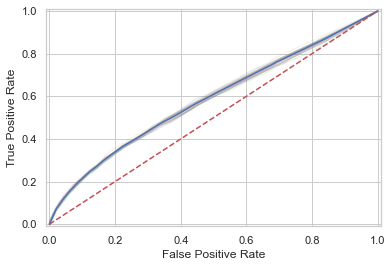

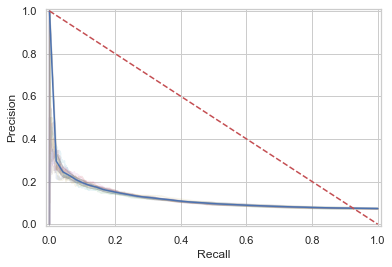

In [24]:
###Data
y1 = logit_data["conversion"].to_numpy()
X1 = np.array(logit_data["X1"].to_list())
X1 = sm.add_constant(X1)

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_prc_insample_fold = []
auc_prc_fold = []
auc_insample_fold = []
tprs = []
precisions = []
TDL_fold = []
TDL_fold_insample = []

base_fpr = np.linspace(0, 1)
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()


for train_index, test_index in sss.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

    # Logit 1 Model and probability prediction
    Logit1 = sm.Logit(y_train, X_train).fit()
    y_pred_proba = Logit1.predict(X_test)
    y_pred_prob_insample = Logit1.predict(X_train)
    clear_output(wait=True)

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # ROC and Precision Recall curve calculation
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)

    ax1.plot(fpr, tpr, alpha=0.15)
    ax2.plot(recall, precision, alpha=0.15)

    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    tprs.append(tpr1)
    precisions.append(precision1)

    auc_fold.append(metrics.auc(fpr, tpr))
    auc_prc_fold.append(metrics.auc(recall, precision))

    # In-Sample metrics
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Logit Model 1"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

## Logit 2

--------------------------
Mean AUC Out-of-Sample 0.5861756976698337 0.005983348981036337
Mean AUC Within Sample 0.5870032915366739 0.0007223922797409848
Mean Top-Decile-Lift Out-of-Sample 1.9925005201648065 0.05023967902603584
Mean Top-Decile-Lift In-Sample 1.9975362617304373 0.005650939320799955
Mean AUC PRC Out-of-Sample 0.10908308116831957 0.0033587702202171454
Mean AUC Within Sample 0.1093154187235982 0.0003411321745826802


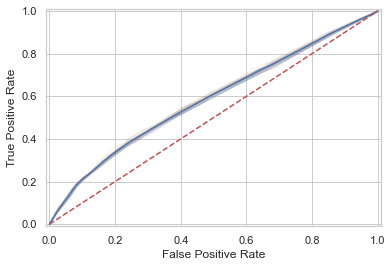

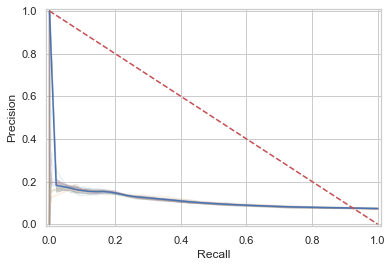

In [25]:
###Data
y2 = logit_data["conversion"].to_numpy()
X2 = np.array(logit_data["X2"].to_list())
X2 = sm.add_constant(X2)

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in sss.split(X2, y2):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y2[train_index], y2[test_index]

    # Logit 2 Model and probability prediction
    Logit2 = sm.Logit(y_train, X_train).fit(maxiter=100000, method="bfgs")
    y_pred_proba = Logit2.predict(X_test)
    y_pred_prob_insample = Logit2.predict(X_train)
    clear_output(wait=True)

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # Out of sample roc curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Logit Model 2"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

## First Touch

--------------------------
Mean AUC Out-of-Sample 0.5432070286048182 0.006954051895999417
Mean AUC Within Sample 0.5442640196219496 0.0007585737369103738
Mean Top-Decile-Lift Out-of-Sample 1.2814791198437279 0.05976659713404254
Mean Top-Decile-Lift In-Sample 1.2808345027355037 0.012856963877941897
Mean AUC PRC Out-of-Sample 0.16717581645545954 0.005423480269852682
Mean AUC Within Sample 0.16726553296533148 0.0005934326533570424
Attribution Results {'Instagram': 0.21507227222473635, 'Online Display': 0.16666410011635172, 'Paid Search': 0.164957965191519, 'Facebook': 0.20466452040063868, 'Online Video': 0.2486411420667542}
Attribution Standard Deviation {'Instagram': 0.00044891281877073013, 'Online Display': 0.000524624267830779, 'Paid Search': 0.00020593487453664518, 'Facebook': 0.0002585231651795149, 'Online Video': 0.0005635939485196186}


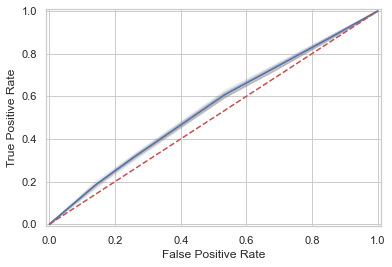

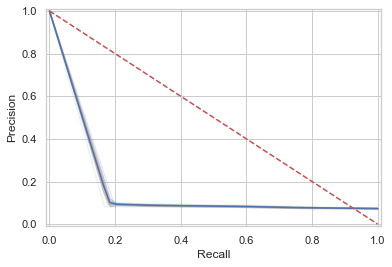

In [26]:
###Data
y = Data["conversion"].to_numpy()
X = Data["first_touch"].to_numpy()

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
Attribution = []

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # First Touch rule
    model = Heuristic(X_train, y_train)
    model.fit_touch()

    y_pred_proba = model.predict_touch(X_test)
    y_pred_prob_insample = model.predict_touch(X_train)

    # TDL Calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # Out of sample roc curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))

    # Attribution
    Attribution.append(model.prob_first)

### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["First Touch"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

Mean_Attribution = {}
std_Attribution = {}
Mean_Attribution_Prop = {}
buffer = []
for channel in channels:
    for probs in Attribution:
        buffer.append(probs[channel])
    Mean_Attribution[channel] = statistics.mean(buffer)
    std_Attribution[channel] = statistics.stdev(buffer)
    buffer = []

for i in Mean_Attribution:
    Mean_Attribution_Prop[i] = Mean_Attribution[i] / sum(Mean_Attribution.values())

print("Attribution Results", Mean_Attribution_Prop)
print("Attribution Standard Deviation", std_Attribution)

## Last Touch

--------------------------
Mean AUC Out-of-Sample 0.54410993563881 0.005099674211054234
Mean AUC Within Sample 0.5441099948546183 0.0005651384080844608
Mean Top-Decile-Lift Out-of-Sample 1.312106956887228 0.07267672488514502
Mean Top-Decile-Lift In-Sample 1.321931894443229 0.01656380420099396
Mean AUC PRC Out-of-Sample 0.17290355421181527 0.005238693817635245
Mean AUC Within Sample 0.17291736392372598 0.0005821423436784737
Attribution Results {'Instagram': 0.20228684053127555, 'Online Display': 0.1648981039607709, 'Paid Search': 0.16934384936577157, 'Facebook': 0.20465834943623676, 'Online Video': 0.2588128567059452}
Attribution Standard Deviation {'Instagram': 0.0005085908145955777, 'Online Display': 0.0005231152204650281, 'Paid Search': 0.00027568805322759617, 'Facebook': 0.0003164678934475703, 'Online Video': 0.0005679512913855834}


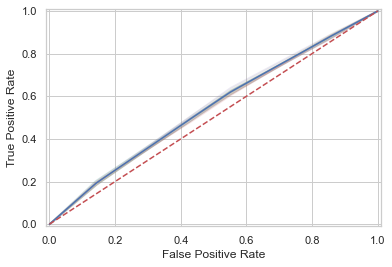

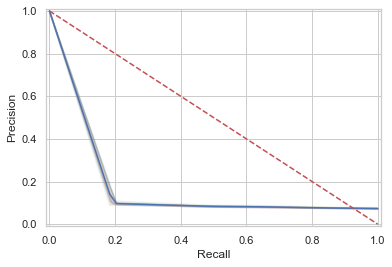

In [27]:
###Data

y = Data["conversion"].to_numpy()
X = Data["last_touch"].to_numpy()

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
Attribution = []

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Last Touch rule
    model = Heuristic(X_train, y_train)
    model.fit_touch()

    y_pred_proba = model.predict_touch(X_test)
    y_pred_prob_insample = model.predict_touch(X_train)

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # Out of sample roc curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))

    Attribution.append(model.prob_first)


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Last Touch"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

Mean_Attribution = {}
std_Attribution = {}
Mean_Attribution_Prop = {}
buffer = []
for channel in channels:
    for probs in Attribution:
        buffer.append(probs[channel])
    Mean_Attribution[channel] = statistics.mean(buffer)
    std_Attribution[channel] = statistics.stdev(buffer)
    buffer = []

for i in Mean_Attribution:
    Mean_Attribution_Prop[i] = Mean_Attribution[i] / sum(Mean_Attribution.values())

print("Attribution Results", Mean_Attribution_Prop)
print("Attribution Standard Deviation", std_Attribution)

## Markov Model Order 1

10it [10:20, 62.00s/it]


--------------------------
Mean AUC Out-of-Sample 0.5301417588023948 0.013881300538166812
Mean AUC Within Sample 0.5309723759989449 0.01436350842463435
Mean Top-Decile-Lift Out-of-Sample 1.211516443239392 0.1212449549125965
Mean Top-Decile-Lift In-Sample 1.2406706736329371 0.13899524215787462
Mean AUC PRC Out-of-Sample 0.17744492085898853 0.021937780091021177
Mean AUC Within Sample 0.17685771726565366 0.02244404954333495
Attribution Results {'Instagram': 0.16618728336517422, 'Online Display': 0.12020022000908302, 'Paid Search': 0.2564176692321907, 'Facebook': 0.3043752436486962, 'Online Video': 0.15281958374485574}
Attribution Standard Deviation {'Instagram': 0.01252193268179243, 'Online Display': 0.0062242757927714375, 'Paid Search': 0.009599356828951579, 'Facebook': 0.015281132142310923, 'Online Video': 0.008014100476172993}


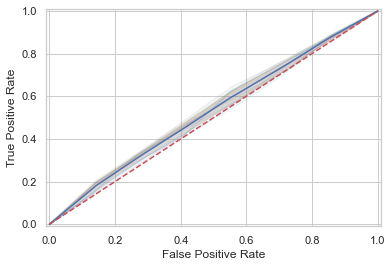

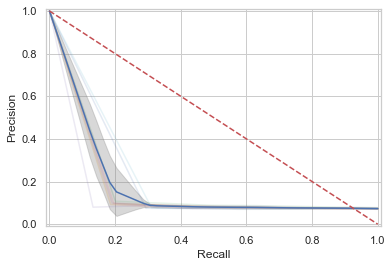

In [28]:
###Data
y = Data["conversion"].to_numpy()
X = Data["path"].to_numpy()
X1 = Data["last_touch"].to_numpy()

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
Removal_Effects = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
y_pred_proba = np.empty(0)

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in tqdm(sss.split(X1, y)):
    y_pred_proba = np.empty(0)
    y_pred_prob_insample = np.empty(0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X1_train, X1_test = X1[train_index], X1[test_index]

    # Calculate Transition matrix for fold
    list_of_paths = X_train
    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix_order1 = transition_matrix(list_of_paths, trans_prob)

    # Determine eventual conversion and removal effects
    simulation_conversions = run_simulation(trans_matrix_order1)

    # Predict probabilities using eventual conversion
    for i in X1_test:
        y_pred_proba = np.append(
            y_pred_proba,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # In-Sample: Predict probabilities using eventual conversion
    for i in X1_train:
        y_pred_prob_insample = np.append(
            y_pred_prob_insample,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # Calculate removal effects for attribution
    Removal_Effects.append(
        dict(
            zip(
                simulation_conversions["State"],
                simulation_conversions["Removal_Effect"],
            )
        )
    )
    
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))
    clear_output(wait=True)


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Markov 1"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

Mean_RE = {}
std_RE = {}
Mean_RE_Prop = {}
buffer = []
for channel in channels:
    for probs in Removal_Effects:
        buffer.append(probs[channel])
    Mean_RE[channel] = statistics.mean(buffer)
    std_RE[channel] = statistics.stdev(buffer)
    buffer = []

for i in Mean_RE:
    Mean_RE_Prop[i] = Mean_RE[i] / sum(Mean_RE.values())

print("Attribution Results", Mean_RE_Prop)
print("Attribution Standard Deviation", std_RE)

## Markov Model Order 2

10it [02:54, 17.43s/it]

--------------------------
Mean AUC Out-of-Sample 0.5495123817268286 0.016968669353591075
Mean AUC Within Sample 0.5491195731872771 0.009587721334628036
Mean Top-Decile-Lift Out-of-Sample 1.1081592246583138 0.1122821937729321
Mean Top-Decile-Lift In-Sample 1.1087956535301764 0.08092300540050563
Mean AUC PRC Out-of-Sample 0.12134505024276532 0.006068203263894619
Mean AUC Within Sample 0.12213441455019447 0.0060714905956489726
                Instagram  Online Display  Paid Search  Facebook  Online Video
Instagram        0.050342        0.008051     0.015272  0.116454      0.007455
Online Display   0.007543        0.050098     0.023310  0.011811      0.002824
Paid Search      0.010664        0.025211     0.110487  0.025638      0.010512
Facebook         0.117773        0.014675     0.032883  0.152060      0.020339
Online Video     0.010845        0.006672     0.020994  0.022605      0.125482


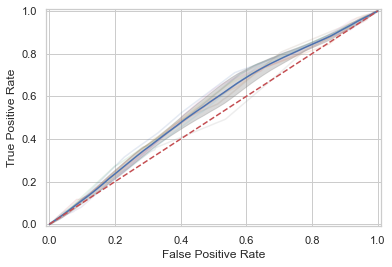

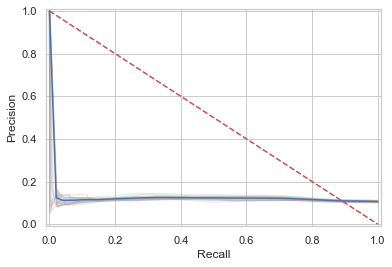

In [29]:
###Data

y = Data[Data["last_2_touch"] != 0]["conversion"].to_numpy()
X = Data[Data["last_2_touch"] != 0]["Arc_str"].to_numpy()
X1 = Data[Data["last_2_touch"] != 0]["last_2_touch"].to_numpy()

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
Attribution2 = pd.DataFrame(np.zeros((len(channels), len(channels))), columns=channels)
Attribution2 = Attribution2.set_index(pd.Index(channels))

y_pred_proba = np.empty(0)

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in tqdm(sss.split(X1, y)):
    y_pred_proba = np.empty(0)
    y_pred_prob_insample = np.empty(0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X1_train, X1_test = X1[train_index], X1[test_index]

    
    # Calculate Transition matrix for fold
    list_of_paths = X_train
    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix_order2 = transition_matrix(list_of_paths, trans_prob)

    # Determine eventual conversion and removal effects
    simulation_conversions = run_simulation(trans_matrix_order2)

    # Predict probabilities using eventual conversion
    for i in X1_test:
        y_pred_proba = np.append(
            y_pred_proba,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )
        
    # In-Sample: Predict probabilities using eventual conversion
    for i in X1_train:
        y_pred_prob_insample = np.append(
            y_pred_prob_insample,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))
    
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))
    clear_output(wait=True)

    # Calculate removal effects for attribution
    for i in range(len(simulation_conversions)):
        if (
            simulation_conversions.iloc[i]["State"].split(" , ")[0]
            in Attribution2.index
        ):
            j = simulation_conversions.iloc[i]["State"].split(" , ")[0]
            k = simulation_conversions.iloc[i]["State"].split(" , ")[1]
            number = simulation_conversions.iloc[i]["Removal_Effect"]
            Attribution2[j][k] += number


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Markov 2"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

# Attribution
new_values = Attribution2.to_numpy()
new_values = new_values / 10
new_values = new_values / np.sum(new_values)
Attribution2[:] = new_values
print(Attribution2)

## Markov Model Order 3

10it [02:45, 16.52s/it]


--------------------------
Mean AUC Out-of-Sample 0.5266303449337532 0.01777089739990824
Mean AUC Within Sample 0.5359213632415012 0.012162350391225114
Mean Top-Decile-Lift Out-of-Sample 0.9412813343128562 0.11469989133287149
Mean Top-Decile-Lift In-Sample 1.0556220973187935 0.08988733826189167
Mean AUC PRC Out-of-Sample 0.12846299154974924 0.004447331076785222
Mean AUC Within Sample 0.13137902800767615 0.0038351735058088734


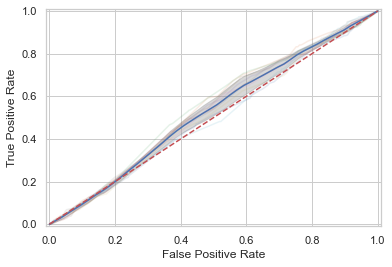

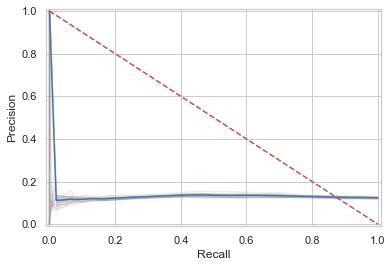

In [30]:
###Data

y = Data[Data["last_3_touch"] != 0]["conversion"].to_numpy()
X = Data[Data["last_3_touch"] != 0]["Arc_3_str"].to_numpy()
X1 = Data[Data["last_3_touch"] != 0]["last_3_touch"].to_numpy()

sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
y_pred_proba = np.empty(0)

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for train_index, test_index in tqdm(sss.split(X1, y)):
    y_pred_proba = np.empty(0)
    y_pred_prob_insample = np.empty(0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X1_train, X1_test = X1[train_index], X1[test_index]
 
    # Calculate Transition matrix for fold
    list_of_paths = X_train
    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix_order3 = transition_matrix(list_of_paths, trans_prob)
    
    # Determine eventual conversion and removal effects
    simulation_conversions = run_simulation(trans_matrix_order3)

    # Predict probabilities using eventual conversion
    for i in X1_test:
        y_pred_proba = np.append(
            y_pred_proba,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # In-Sample: Predict probabilities using eventual conversion
    for i in X1_train:
        y_pred_prob_insample = np.append(
            y_pred_prob_insample,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))
    clear_output(wait=True)


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["Markov 3"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

In [31]:
Predictive_acc

,Logit Model 1,Logit Model 2,First Touch,Last Touch,Markov 1,Markov 2,Markov 3
0,0.586701,0.587003,0.544264,0.544110,0.530972,0.549120,0.535921
1,0.000843,0.000722,0.000759,0.000565,0.014364,0.009588,0.012162
2,0.586169,0.586176,0.543207,0.544110,0.530142,0.549512,0.526630
3,0.006729,0.005983,0.006954,0.005100,0.013881,0.016969,0.017771
4,2.025319,1.997536,1.280835,1.321932,1.240671,1.108796,1.055622
5,0.007956,0.005651,0.012857,0.016564,0.138995,0.080923,0.089887
6,2.029990,1.992501,1.281479,1.312107,1.211516,1.108159,0.941281
7,0.055626,0.050240,0.059767,0.072677,0.121245,0.112282,0.114700
8,0.119359,0.109315,0.167266,0.172917,0.176858,0.122134,0.131379
9,0.000267,0.000341,0.000593,0.000582,0.022444,0.006071,0.003835


# Neural Network Markov Model Extension

## Transformation and Output Smoothing

In [32]:
# Exponential transformation of time probability
def Exponential_pdf(lamb, x):
    return lamb * math.exp(-lamb * x)

In [33]:
# Smoothing loss function for class imbalance
class label_smooth_loss(torch.nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(label_smooth_loss, self).__init__()
        eps = smoothing / num_classes
        self.negative = eps
        self.positive = (1 - smoothing) + eps

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.negative)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.positive)
        return torch.sum(-true_dist * pred, dim=1).mean()

In [34]:
class NN(nn.Module):
    def __init__(self, input_size=2, num_classes=1, seq_num=0):
        super(NN, self).__init__()
        self.layer_list = []
        # Creating stacked linear layers
        for i in range(seq_num):
            self.layer_list.append("fc" + str(i + 1))
        for attr in self.layer_list:
            setattr(self, attr, nn.Linear(input_size, num_classes))
        self.seq_num = seq_num

    def forward(self, x1, x2):
        y = torch.empty(0)
        i = 0
        # Formatting X and Y into stacked format
        for attr in self.layer_list:
            x = torch.from_numpy(np.column_stack((x1[:, i], x2[:, i])))
            y = torch.cat((y, getattr(self, attr)(x.float())), 1)
            i += 1

        y_final = nn.Softmax(dim=1)(y)

        return y_final

In [35]:
from numpy import inf


def Neural_Network_run(
    trans_matrix,
    arcs,
    times,
    channels,
    batch_size=64,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=10,
    learning_rate=0.001,
):
    
    ## Data preperation by flattening arcs and creating X_time and X_Markov respectively
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output = pd.DataFrame()
    flatten_arcs = [j for sub in arcs for j in sub]
    flatten_time = [j for sub in times for j in sub]
    v_func = np.vectorize(Exponential_pdf)
    flatten_time = np.array(flatten_time)
    flatten_time = flatten_time / np.max(flatten_time)
    flatten_time = v_func(np.mean(flatten_time), flatten_time).tolist()
    channels_code_nump = {}
    count = 0
    for i in channels:
        channels_code_nump[i] = count
        count += 1
    channels_code_nump["Null"] = count
    channels_code_nump["Conversion"] = count + 1
    x_prob = np.zeros((len(flatten_arcs), len(channels_code_nump)), dtype=float)
    x_time = np.zeros((len(flatten_time), len(channels_code_nump)), dtype=float)
    y_out = np.empty(0, dtype=float)
    base = np.empty(0, dtype=float)

    counter = 0
    # Transforming vectors
    for i in flatten_arcs:
        x_prob[counter, channels_code_nump[i[1]]] = math.log(trans_matrix[i[1]][i[0]])
        x_time[counter, channels_code_nump[i[1]]] = flatten_time[counter]
        y_out = np.append(y_out, channels_code_nump[i[1]])
        base = np.append(base, channels_code_nump[i[0]])
        counter += 1

    channel_transition_prob = {}
    for i in channels:
        p = np.empty(0)
        for j in channels_code_nump:
            p = np.append(p, trans_matrix[j][i])
        channel_transition_prob[i] = p
    
    # For every channel as starting node perform neural entwork for transition probabilities
    for keys in tqdm(channels):
        # Determine base and load data
        ind = np.where(base == channels_code_nump[keys])
    
        x1 = torch.from_numpy(x_prob[ind])
        x2 = torch.from_numpy(x_time[ind])

        y = torch.from_numpy(y_out[ind]).type(torch.LongTensor)

        ds_train = TensorDataset(torch.cat((x1, x2), 1), y)
        train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

        seq_num = len(channels_code_nump)

        model = NN(input_size=2, num_classes=1, seq_num=seq_num).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            for batch_idx, (data, targets) in enumerate(train_loader):
                # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)
                # forward propagation
                scores = model(data[:, :seq_num], data[:, seq_num : 2 * seq_num])
                loss = criterion(scores, targets)
                # zero previous gradients
                optimizer.zero_grad()

                # back-propagation
                loss.backward()

                # gradient descent
                optimizer.step()
        
        # Aggregate data for prediction of transition probabilities
        x1 = x_time[ind].mean(axis=0)
        x1 = x1 / np.max(x1)
        x_time_predict = torch.from_numpy(x1)
        x_prob_predict = torch.from_numpy(np.log(channel_transition_prob[keys]))
        x_prob_predict = x_prob_predict.reshape((-1, len(x_prob_predict)))
        x_prob_predict[x_prob_predict == -inf] = -10
        x_time_predict = x_time_predict.reshape((-1, len(x_time_predict)))
        y = model(x_prob_predict, x_time_predict)
        prob_dict = {}
        count_dict = 0
        for i in channels_code_nump:
            prob_dict[i] = y[0, count_dict].item()
            count_dict += 1
        row = pd.Series(prob_dict, name=keys)
        output = output.append(row)

    output["Start"] = 0
    output = output.append(trans_matrix.loc["Start"])
    output = output.append(trans_matrix.loc["Null"])
    output = output.append(trans_matrix.loc["Conversion"])

    return output

## NN Markov 1

10it [31:38, 189.83s/it]


--------------------------
Mean AUC Out-of-Sample 0.5277918153186737 0.007899925121813797
Mean AUC Within Sample 0.5283975678472447 0.008975275729990745
Mean Top-Decile-Lift Out-of-Sample 1.2751601533814476 0.15467146115014144
Mean Top-Decile-Lift In-Sample 1.2795705931923562 0.16030257651645063
Mean AUC PRC Out-of-Sample 0.1657079411931468 0.01318250548727993
Mean AUC Within Sample 0.16635633439712336 0.012488493357080365
Attribution Results {'Instagram': 0.2146602704439518, 'Online Display': 0.1831667067935779, 'Paid Search': 0.153253125226973, 'Facebook': 0.18820222623045063, 'Online Video': 0.26071767130504664}
Attribution Std {'Instagram': 0.06047121368621453, 'Online Display': 0.07864616343964315, 'Paid Search': 0.03901333094805282, 'Facebook': 0.07308805834908175, 'Online Video': 0.05852648271812152}
Channel Arc Differences {'Null': -0.9142314202840387, 'Conversion': 0.12986492323754217, 'Instagram': -0.00469435546687782, 'Online Display': 0.06902319182757904, 'Paid Search': 0.2

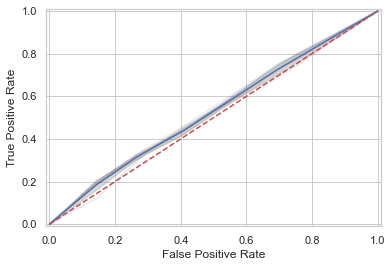

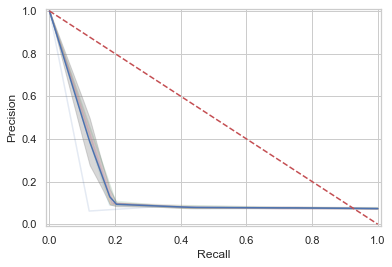

In [36]:
###Data
y = Data["conversion"].to_numpy()
X = Data["path"].to_numpy()
X1 = Data["last_touch"].to_numpy()
X_arc = Data["Arc"].to_numpy()
X_time_diff = Data["time_diff"].to_numpy()


sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
Removal_Effects = []
y_pred_proba = np.empty(0)

base_fpr = np.linspace(0, 1)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
channel_AD_incoming = {}


for train_index, test_index in tqdm(sss.split(X1, y)):
    y_pred_proba = np.empty(0)
    y_pred_prob_insample = np.empty(0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X1_train, X1_test = X1[train_index], X1[test_index]
    X_arc_train, X_arc_test = X_arc[train_index], X_arc[test_index]
    X_time_diff_train, X_time_diff_test = (
        X_time_diff[train_index],
        X_time_diff[test_index],
    )
    
    # Calculate Transition matrix for fold
    list_of_paths = X_train
    total_conversions = sum(path.count("Conversion") for path in Data["path"].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)

    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix_order1 = transition_matrix(list_of_paths, trans_prob)

    # Neural Network Run for new transition probabilities
    New_Transition_Matrix = Neural_Network_run(
        trans_matrix_order1,
        arcs=X_arc_train,
        times=X_time_diff_train,
        channels=df["channel"].unique(),
        criterion=label_smooth_loss(num_classes=7, smoothing=0.5),
    )
    
    # Determine eventual conversion and removal effects
    simulation_conversions = run_simulation(New_Transition_Matrix)
    
    # Predict probabilities using eventual conversion
    for i in X1_test:
        y_pred_proba = np.append(
            y_pred_proba,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # In-Sample: Predict probabilities using eventual conversion
    for i in X1_train:
        y_pred_prob_insample = np.append(
            y_pred_prob_insample,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )
    
    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))
    
    # Calculate removal effects for attribution
    Removal_Effects.append(
        dict(
            zip(
                simulation_conversions["State"],
                simulation_conversions["Removal_Effect"],
            )
        )
    )
    
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))

    ## Arc Difference
    for i in trans_matrix_order1.index:
        for j in trans_matrix_order1.index:
            if i in channel_AD_incoming:
                channel_AD_incoming[i] += (
                    New_Transition_Matrix[i][j] - trans_matrix_order1[i][j]
                )
            else:
                channel_AD_incoming[i] = (
                    New_Transition_Matrix[i][j] - trans_matrix_order1[i][j]
                )

    clear_output(wait=True)


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["NN Markov 1"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

Mean_RE = {}
std_RE = {}
Mean_RE_Prop = {}
buffer = []
for channel in channels:
    for probs in Removal_Effects:
        buffer.append(probs[channel])
    Mean_RE[channel] = statistics.mean(buffer)
    std_RE[channel] = statistics.stdev(buffer)
    buffer = []

for i in Mean_RE:
    Mean_RE_Prop[i] = Mean_RE[i] / sum(Mean_RE.values())

print("Attribution Results", Mean_RE_Prop)
print("Attribution Std", std_RE)

## Arc Difference
for i in channel_AD_incoming:
    channel_AD_incoming[i] = channel_AD_incoming[i] / 10


print("Channel Arc Differences", channel_AD_incoming)

## NN Markov 2

10it [46:19, 277.94s/it]


--------------------------
Mean AUC Out-of-Sample 0.5373377321194155 0.03014262645876996
Mean AUC Within Sample 0.5334193593905807 0.02567650769800435
Mean Top-Decile-Lift Out-of-Sample 1.2302910289528948 0.16352054941419353
Mean Top-Decile-Lift In-Sample 1.2053252214326104 0.20040478726702848
Mean AUC PRC Out-of-Sample 0.1790786212455983 0.04637461414600664
Mean AUC Within Sample 0.17711735562421035 0.050353771231488355
                Instagram  Online Display  Paid Search  Facebook  Online Video
Instagram        0.040973        0.020078     0.026924  0.074312      0.015952
Online Display   0.026247        0.046218     0.033790  0.029851      0.021776
Paid Search      0.026223        0.024518     0.091866  0.038077      0.025127
Facebook         0.080146        0.020136     0.038936  0.096759      0.022081
Online Video     0.022590        0.018307     0.027521  0.034674      0.096919
Channel Arc Differences {'Instagram , Paid Search': 0.6013547998392245, 'Paid Search , Instagram': 0.

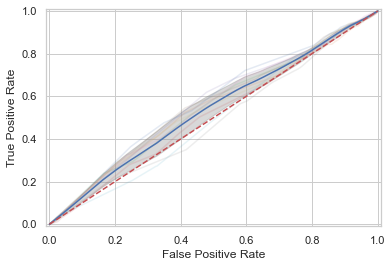

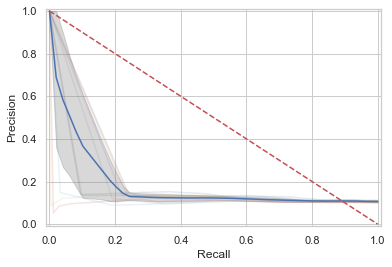

In [38]:
###Data

y = Data[Data["last_2_touch"] != 0]["conversion"].to_numpy()
X = Data[Data["last_2_touch"] != 0]["Arc_str"].to_numpy()
X1 = Data[Data["last_2_touch"] != 0]["last_2_touch"].to_numpy()
X_arc = Data[Data["last_2_touch"] != 0]["Arc_2nd_order"].to_numpy()
X_time_diff = Data[Data["last_2_touch"] != 0]["time_diff"].to_numpy()


sss = KFold(n_splits=10, shuffle=True, random_state=0)

auc_fold = []
auc_insample_fold = []
tprs = []
TDL_fold = []
TDL_fold_insample = []
Removal_Effects = []
auc_prc_insample_fold = []
auc_prc_fold = []
precisions = []
Attribution2 = pd.DataFrame(np.zeros((len(channels), len(channels))), columns=channels)
Attribution2 = Attribution2.set_index(pd.Index(channels))

y_pred_proba = np.empty(0)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

base_fpr = np.linspace(0, 1)
channel_AD_incoming = {}

for train_index, test_index in tqdm(sss.split(X, y)):
    y_pred_proba = np.empty(0)
    y_pred_prob_insample = np.empty(0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X1_train, X1_test = X1[train_index], X1[test_index]
    X_arc_train, X_arc_test = X_arc[train_index], X_arc[test_index]
    X_time_diff_train, X_time_diff_test = (
        X_time_diff[train_index],
        X_time_diff[test_index],
    )

    # Calculate Transition matrix for fold
    list_of_paths = X_train
    total_conversions = sum(path.count("Conversion") for path in Data["path"].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)

    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix_order2 = transition_matrix(list_of_paths, trans_prob)
    
    # Neural Network Run for new transition probabilities
    New_Transition_Matrix = Neural_Network_run(
        trans_matrix_order2,
        arcs=X_arc_train,
        times=X_time_diff_train,
        channels=channels_2_order,
        criterion=label_smooth_loss(num_classes=27, smoothing=0.5),
    )
    
    # Determine eventual conversion and removal effects
    simulation_conversions = run_simulation(New_Transition_Matrix)

    # Predict probabilities using eventual conversion
    for i in X1_test:
        y_pred_proba = np.append(
            y_pred_proba,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # In-Sample: Predict probabilities using eventual conversion
    for i in X1_train:
        y_pred_prob_insample = np.append(
            y_pred_prob_insample,
            simulation_conversions[simulation_conversions["State"] == i][
                "Eventual_Conversion"
            ],
        )

    # TDL calculation
    TDL_fold.append(decile_lift(y_test, y_pred_proba))
    TDL_fold_insample.append(decile_lift(y_train, y_pred_prob_insample))

    # Calculate removal effects for attribution
    Removal_Effects.append(
        dict(
            zip(
                simulation_conversions["State"],
                simulation_conversions["Removal_Effect"],
            )
        )
    )
    
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, alpha=0.15)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    tpr1[0] = 0.0
    tprs.append(tpr1)
    auc_fold.append(metrics.auc(fpr, tpr))

    # In-Sample
    fpr_in, tpr_in, _ = metrics.roc_curve(y_train, y_pred_prob_insample)
    auc_insample_fold.append(metrics.auc(fpr_in, tpr_in))

    # Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, alpha=0.15)
    precision1 = np.interp(base_fpr, recall[::-1], precision[::-1])
    precision1[0] = 1.0
    precisions.append(precision1)
    auc_prc_fold.append(metrics.auc(recall, precision))
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        y_train, y_pred_prob_insample
    )
    auc_prc_insample_fold.append(metrics.auc(recall_in, precision_in))
    clear_output(wait=True)

    # Attribution
    for i in range(len(simulation_conversions)):
        if (
            simulation_conversions.iloc[i]["State"].split(" , ")[0]
            in Attribution2.index
        ):
            j = simulation_conversions.iloc[i]["State"].split(" , ")[0]
            k = simulation_conversions.iloc[i]["State"].split(" , ")[1]
            number = simulation_conversions.iloc[i]["Removal_Effect"]
            Attribution2[j][k] += number

    ## Arc Difference
    for i in trans_matrix_order2.index:
        for j in trans_matrix_order2.index:
            if i in channel_AD_incoming:
                channel_AD_incoming[i] += (
                    New_Transition_Matrix[i][j] - trans_matrix_order2[i][j]
                )
            else:
                channel_AD_incoming[i] = (
                    New_Transition_Matrix[i][j] - trans_matrix_order2[i][j]
                )

    clear_output(wait=True)


### Plotting
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

precisions = np.array(precisions)
mean_precisions = precisions.mean(axis=0)
std_precisions = precisions.std(axis=0)

precisions_upper = np.minimum(mean_precisions + std_precisions, 1)
precisions_lower = mean_precisions - std_precisions


ax1.plot(base_fpr, mean_tprs)
ax1.fill_between(base_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3)

ax1.plot([0, 1], [0, 1], "r--")
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(base_fpr, mean_precisions)
ax2.fill_between(base_fpr, precisions_lower, precisions_upper, color="grey", alpha=0.3)

ax2.plot([0, 1], [1, 0], "r--")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")


print("--------------------------")
print("Mean AUC Out-of-Sample", statistics.mean(auc_fold), statistics.stdev(auc_fold))
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
)
print(
    "Mean Top-Decile-Lift Out-of-Sample",
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
)
print(
    "Mean Top-Decile-Lift In-Sample",
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
)
print(
    "Mean AUC PRC Out-of-Sample",
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
)
print(
    "Mean AUC Within Sample",
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
)

Predictive_acc["NN Markov 2"] = [
    statistics.mean(auc_insample_fold),
    statistics.stdev(auc_insample_fold),
    statistics.mean(auc_fold),
    statistics.stdev(auc_fold),
    statistics.mean(TDL_fold_insample),
    statistics.stdev(TDL_fold_insample),
    statistics.mean(TDL_fold),
    statistics.stdev(TDL_fold),
    statistics.mean(auc_prc_insample_fold),
    statistics.stdev(auc_prc_insample_fold),
    statistics.mean(auc_prc_fold),
    statistics.stdev(auc_prc_fold),
]

# Attribution
new_values = Attribution2.to_numpy()
new_values = new_values / 10
new_values = new_values / np.sum(new_values)
Attribution2[:] = new_values
print(Attribution2)

## Arc Difference
for i in channel_AD_incoming:
    channel_AD_incoming[i] = channel_AD_incoming[i] / 10

ArcDifference = pd.DataFrame(np.zeros((len(channels), len(channels))), columns=channels)
ArcDifference = ArcDifference.set_index(pd.Index(channels))

for i in channel_AD_incoming:
    if len(i.split(" , ")) > 1:
        j = i.split(" , ")[0]
        k = i.split(" , ")[1]
        ArcDifference[j][k] = channel_AD_incoming[i]


print("Channel Arc Differences", channel_AD_incoming)
print(ArcDifference)

In [39]:
ArcDifference

,Instagram,Online Display,Paid Search,Facebook,Online Video
Instagram,0.115072,0.433117,0.391213,0.014121,0.503987
Online Display,0.898028,-1.030902,0.489214,0.595895,0.741518
Paid Search,0.601355,0.170512,-0.834104,0.565084,0.504222
Facebook,-0.850351,0.054720,0.313905,-0.555495,0.400495
Online Video,0.606302,0.442635,0.427833,0.813836,-1.934570


In [40]:
Predictive_acc

,Logit Model 1,Logit Model 2,First Touch,Last Touch,Markov 1,Markov 2,Markov 3,NN Markov 1,NN Markov 2
0,0.586701,0.587003,0.544264,0.544110,0.530972,0.549120,0.535921,0.528398,0.533419
1,0.000843,0.000722,0.000759,0.000565,0.014364,0.009588,0.012162,0.008975,0.025677
2,0.586169,0.586176,0.543207,0.544110,0.530142,0.549512,0.526630,0.527792,0.537338
3,0.006729,0.005983,0.006954,0.005100,0.013881,0.016969,0.017771,0.007900,0.030143
4,2.025319,1.997536,1.280835,1.321932,1.240671,1.108796,1.055622,1.279571,1.205325
5,0.007956,0.005651,0.012857,0.016564,0.138995,0.080923,0.089887,0.160303,0.200405
6,2.029990,1.992501,1.281479,1.312107,1.211516,1.108159,0.941281,1.275160,1.230291
7,0.055626,0.050240,0.059767,0.072677,0.121245,0.112282,0.114700,0.154671,0.163521
8,0.119359,0.109315,0.167266,0.172917,0.176858,0.122134,0.131379,0.166356,0.177117
9,0.000267,0.000341,0.000593,0.000582,0.022444,0.006071,0.003835,0.012488,0.050354
